In [1]:
import sys
sys.path.append('..')
from toymodules.salesman import TravelSalesman

In [2]:
from lamarck import BlueprintBuilder, Optimizer
from lamarck.simconfig import ParallelMode

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
from matplotlib import pyplot as plt

# Setup

#### Process

In [4]:
def process_deco(trav_salesman):
    def wrapper(route):
        return {'distance': trav_salesman.get_route_distance(route)}
    return wrapper

In [5]:
n_cities = 10

In [6]:
trav_salesman = TravelSalesman(n_cities, seed=123)

In [7]:
trav_salesman.create.random()

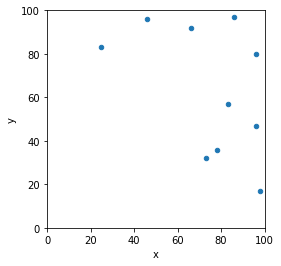

In [8]:
ax = trav_salesman.plot()

# Finding best - Brute Force

In [9]:
gen = itertools.permutations((tuple(range(n_cities))), n_cities)
min_dist = np.inf
N = np.math.factorial(n_cities)
pbar = tqdm(range(N))
for _ in pbar:
    seq = next(gen)
    dist = trav_salesman.get_route_distance(seq)
    if dist < min_dist:
        min_dist = dist
        best_seq = seq

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3628800/3628800 [01:43<00:00, 35077.53it/s]


(1, 5, 8, 4, 2, 9, 3, 0, 6, 7) dist: 184.9066830917233


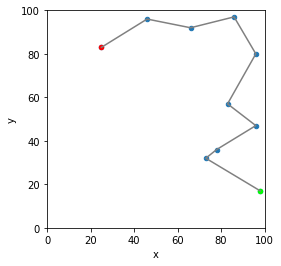

In [10]:
print(best_seq, 'dist:', min_dist)
ax = trav_salesman.plot_route(best_seq)

In [11]:
def get_outputs(func):
    outputs = func.__code__.co_consts
    if isinstance(outputs[-1], tuple):
        return outputs[-1]
    else:
        return (outputs[-1],)

# Finding best - GA

#### Optimization Function

In [9]:
process = process_deco(trav_salesman)

#### Blueprint Creation

In [10]:
builder = BlueprintBuilder()

In [11]:
builder.add_set_gene(name='route',
                     domain=list(range(n_cities)),
                     length=n_cities)

blueprint = builder.get_blueprint()

In [12]:
blueprint

- route
    |- type: set
    |- specs
        |- domain: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        |- length: 10

#### Population

In [13]:
nrand=5000

In [14]:
pop = blueprint.populate.random(nrand)

### Simulate

In [15]:
opt = Optimizer(pop, process)
opt.config.parallel_processing = ParallelMode.MULTITHREAD
opt.config.max_generations = 100
opt.config.peek_champion_variables = ['route', 'distance']

In [19]:
opt.simulate.single_criteria(output='distance', objective='min', quiet=True)

Generation 13 of 100 (stall: 5 of 5) peek: (route: (1, 5, 8, 4, 2, 9, 3, 0, 6, 7) | distance: 184.9066830917233):  13%|▋    | 13/100 [01:57<13:08,  9.06s/it]


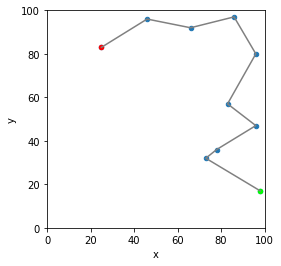

In [20]:
seq = opt.datasets.get_best_criature()['route']
ax = trav_salesman.plot_route(seq)

In [21]:
from lamarck import HistoryExplorer

In [22]:
hist_explorer = HistoryExplorer(opt)

<AxesSubplot:xlabel='generation', ylabel='distance'>

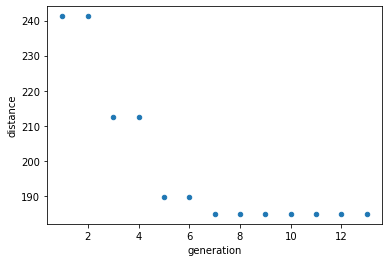

In [23]:
hist_explorer.history('distance', min)

### Solution Evolution

In [24]:
gen = 1

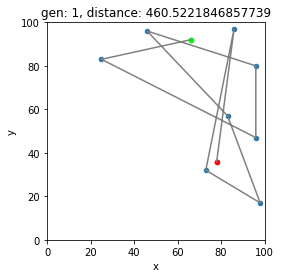

In [25]:
f = opt.datasets.history.generation == gen
df = opt.datasets.history[f]
seq = df.iloc[0]['route']
dist = df.iloc[0]['distance']
ax = trav_salesman.plot_route(seq, title=f'gen: {gen}, distance: {dist}')
gen += 1

# For 20 cities

In [26]:
trav_salesman = TravelSalesman(20, seed=123)
trav_salesman.create.random()

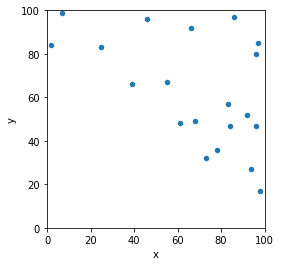

In [27]:
ax = trav_salesman.plot()

In [28]:
process = process_deco(trav_salesman)
builder.add_set_gene(name='route',
                     domain=list(range(20)),
                     length=20)

blueprint = builder.get_blueprint()
new_pop = blueprint.populate.random(nrand)
opt = Optimizer(new_pop, process)

#### Light sim

In [29]:
opt.config.parallel_processing = ParallelMode.MULTITHREAD
opt.config.max_generations = 5
opt.config.max_stall = 5
opt.config.peek_champion_variables = ['route', 'distance']
opt.simulate.single_criteria('distance', 'min', quiet=True)

Generation 5 of 5 (stall: 0 of 5) peek: (route: (0, 11, 14, 17, 10, 19, 8, 15, 5, 1, 2, 4, 6, 12, 16, 7, 13, 3, 18, 9) | distance: 532.8746127003742): 100%|█


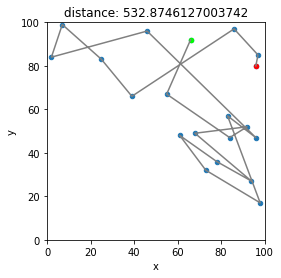

In [30]:
best_creature = opt.datasets.get_best_criature()
dist = trav_salesman.get_route_distance(best_creature['route'])
ax = trav_salesman.plot_route(best_creature['route'], title=f'distance: {dist}')

#### Heavy sim

In [31]:
opt.config.parallel_processing = ParallelMode.MULTITHREAD
opt.config.max_generations = 40
opt.config.max_stall = 10
opt.config.peek_champion_variables = ['distance']
opt.simulate.single_criteria('distance', 'min', quiet=True)

Generation 36 of 40 (stall: 10 of 10) peek: (distance: 299.65948396141124):  90%|███████████████████████████████████████▌    | 36/40 [05:50<00:38,  9.74s/it]


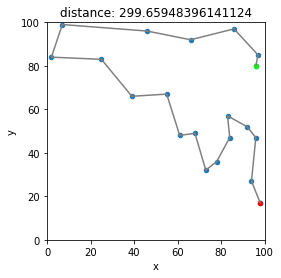

In [32]:
best_creature = opt.datasets.get_best_criature()
dist = trav_salesman.get_route_distance(best_creature['route'])
ax = trav_salesman.plot_route(best_creature['route'], title=f'distance: {dist}')

### Solution Evolution

In [33]:
gen = 1

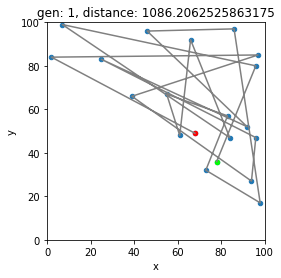

In [34]:
f = opt.datasets.history.generation == gen
df = opt.datasets.history[f]
seq = df.iloc[0]['route']
dist = df.iloc[0]['distance']
ax = trav_salesman.plot_route(seq, title=f'gen: {gen}, distance: {dist}')
gen += 1

### Best I've found so far...

299.65948396141124

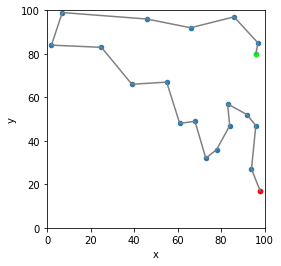

In [35]:
very_best_seq = (9, 18, 3, 0, 6, 16, 12, 7, 13, 11, 15, 10, 5, 8, 14, 2, 17, 4, 19, 1)
trav_salesman.plot_route(very_best_seq)
trav_salesman.get_route_distance(very_best_seq)

# Trying the same thing but with an obvious solution

In [36]:
trav_salesman = TravelSalesman(20, seed=123)

## Straight Line

In [37]:
trav_salesman.create.straightline()

In [38]:
process = process_deco(trav_salesman)
blueprint = builder.get_blueprint()
pop = blueprint.populate.random(nrand)
opt = Optimizer(new_pop, process)

In [39]:
opt.config.max_generations = 40
opt.config.max_stall = 10
opt.config.peek_champion_variables = ['distance']

In [40]:
opt.simulate.single_criteria('distance', 'min', quiet=True)

Generation 31 of 40 (stall: 10 of 10) peek: (distance: 100.00000000000003):  78%|██████████████████████████████████          | 31/40 [05:02<01:27,  9.75s/it]


Is pointless to show the evolution because its all in a straight line but the best solution is 100, so is best to show the difference between the best Creature and the real optimum.

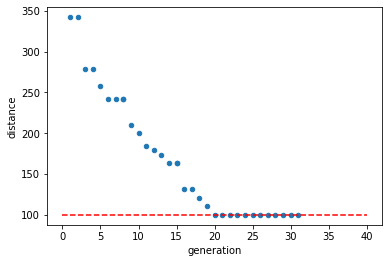

In [41]:
ax = opt.datasets.history[opt.datasets.history['Rank']==1].plot.scatter(x='generation', y='distance')
ax.plot([0, 40], [100, 100], color='r', linestyle='--')

## Circle

In [42]:
trav_salesman.create.circle()

In [43]:
process = process_deco(trav_salesman)
blueprint = builder.get_blueprint()
pop = blueprint.populate.random(nrand)
opt = Optimizer(new_pop, process)

In [44]:
opt.config.max_generations = 40
opt.config.max_stall = 10
opt.config.peek_champion_variables = ['distance']

In [45]:
opt.simulate.single_criteria('distance', 'min', quiet=True)

Generation 40 of 40 (stall: 8 of 10) peek: (distance: 296.27026250532094): 100%|█████████████████████████████████████████████| 40/40 [06:55<00:00, 10.38s/it]


#### Solution Evolution

In [91]:
gen = 1

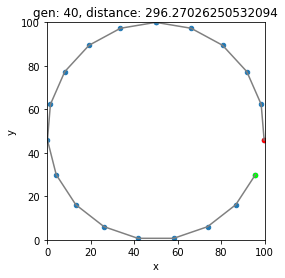

In [131]:
f = opt.datasets.history.generation == gen
df = opt.datasets.history[f]
seq = df.iloc[0]['route']
dist = df.iloc[0]['distance']
ax = trav_salesman.plot_route(seq, title=f'gen: {gen}, distance: {dist}')
gen += 1